## Project: **Advanced Lane Lines ** 
# P4



## Import Packages

In [8]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


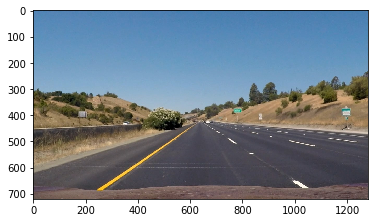

In [9]:
#reading in an image
image = mpimg.imread('test_images/straight_lines1.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [10]:
img_size = image.shape
print(image.shape)
max_x = image.shape[1]
max_y = image.shape[0]

(720, 1280, 3)


## Helper Functions and Line() class

In [11]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

Create a left lane and a right lane

In [12]:
left_lane = Line()
right_lane = Line()

## Camera Calibration

Calibrate the camera with the given images


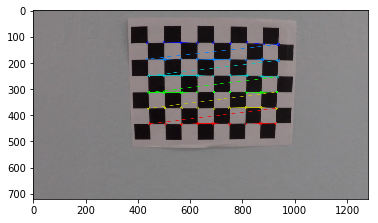

In [13]:
# prepare object points
nx = 9 #number of inside corners in x
ny = 6 #number of inside corners in y

objpoints = []
imgpoints = []
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

for fname in images:
    img = cv2.imread(fname)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)

In [14]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

Let's chose an image and check that we can undistort it

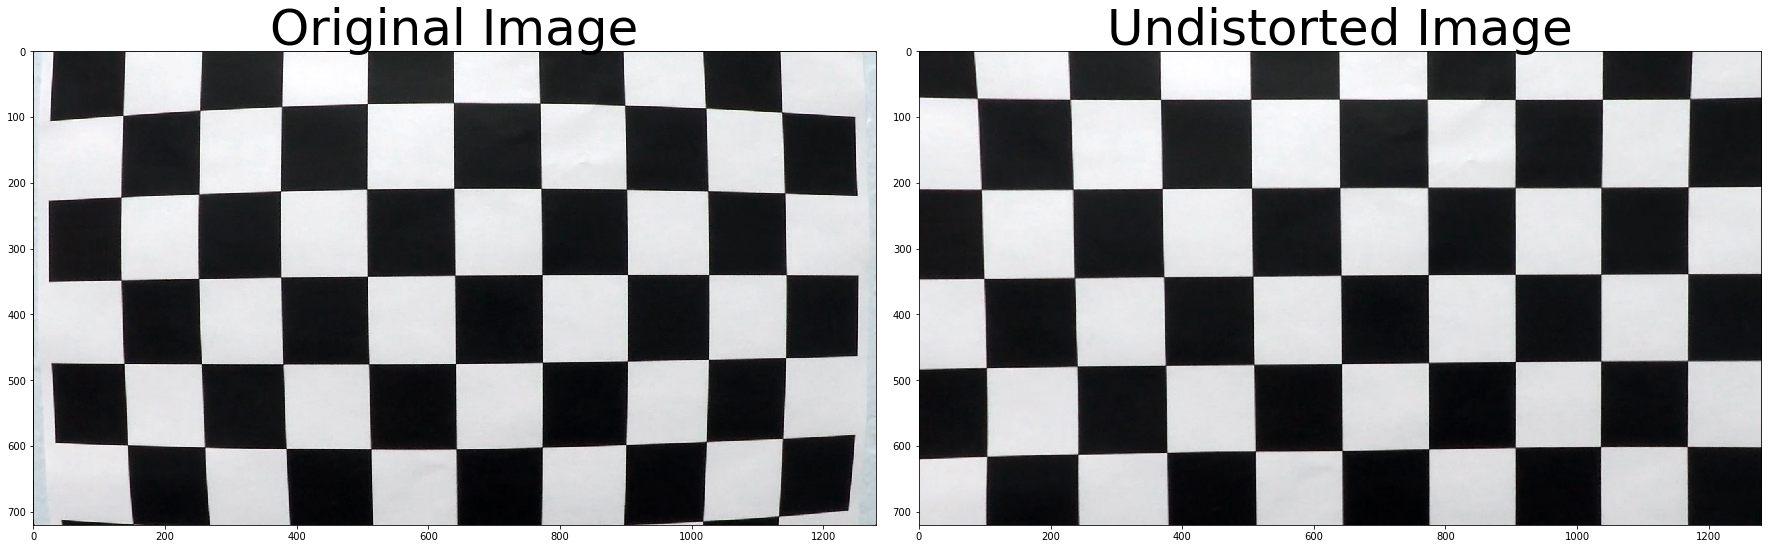

In [15]:
img = images[9]
img = cv2.imread(img)
undistorted = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Tune the parameters

In this section, we will use one image of a straight road to get all the parameters related to the perspective changes and lane finding.

We will tune those parameters to try to achieve the best lane extraction.




In [16]:
# Transform a RGB image into a HLS image
def extract_s_channel_from_BGR(img):
    '''img must be a BGR image'''
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    return hls[:,:,2]
def extract_s_channel_from_RGB(img):
    '''img must be a BGR image'''
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    return hls[:,:,2]

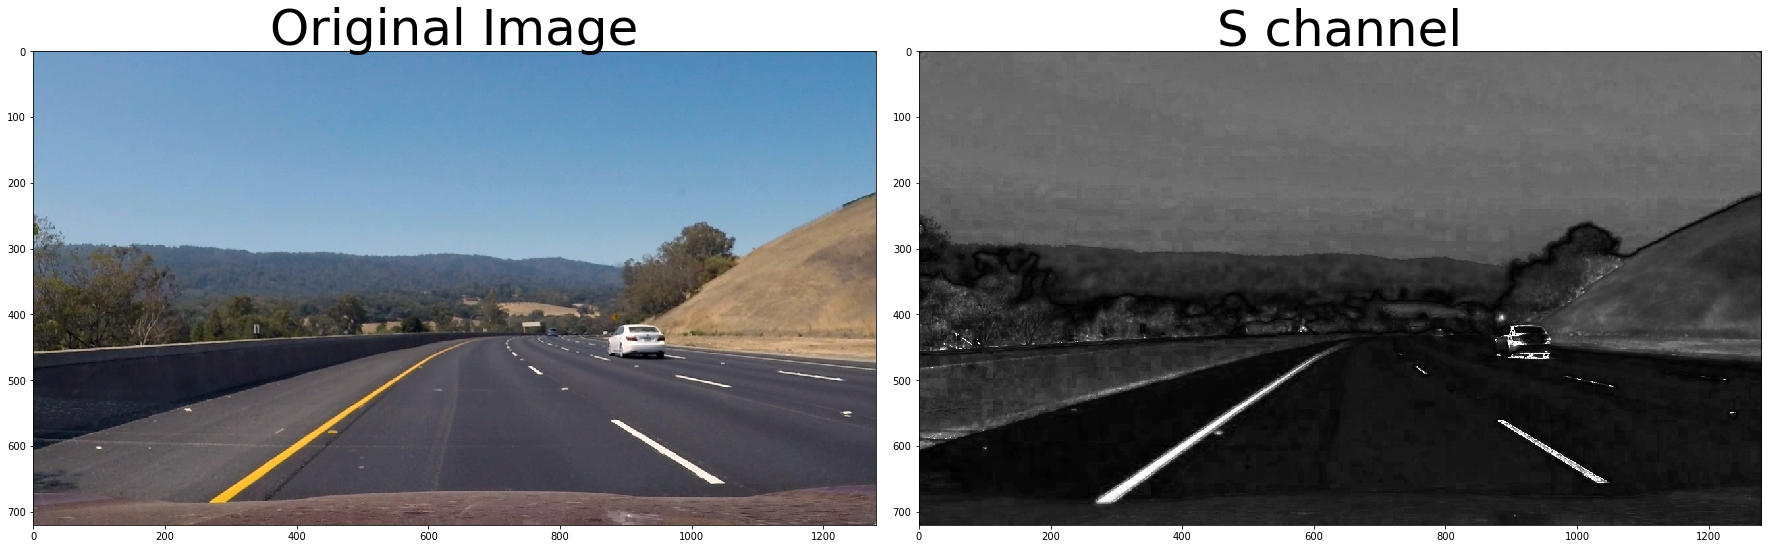

In [17]:
# reading in an image and plot S channel
original_image = mpimg.imread('test_images/test3.jpg')
s_channel = extract_s_channel_from_RGB(original_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(original_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(s_channel, cmap='gray')
ax2.set_title('S channel', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Helper function needed for gradient calculations

In [18]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    if len(img.shape) > 2:
        # it's an BGR image so convert it to gray
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = img
    if orient == 'x':
        sobel = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    if len(img.shape) > 2:
        # it's an BGR image so convert it to gray
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = img
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    sobel_mag = np.sqrt(np.power(sobelx,2)+np.power(sobely,2))
    scaled_sobel = np.uint8(255*sobel_mag/np.max(sobel_mag))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    if len(img.shape) > 2:
        # it's an BGR image so convert it to gray
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = img
    abs_sobelx = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 0, 1,ksize=sobel_kernel))
    grad_direction = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(grad_direction)
    dir_binary[(grad_direction >= thresh[0]) & (grad_direction <= thresh[1])] = 1
    return dir_binary


Let's try our functions on an image. Each steps are plotted to identify the bet parameters.

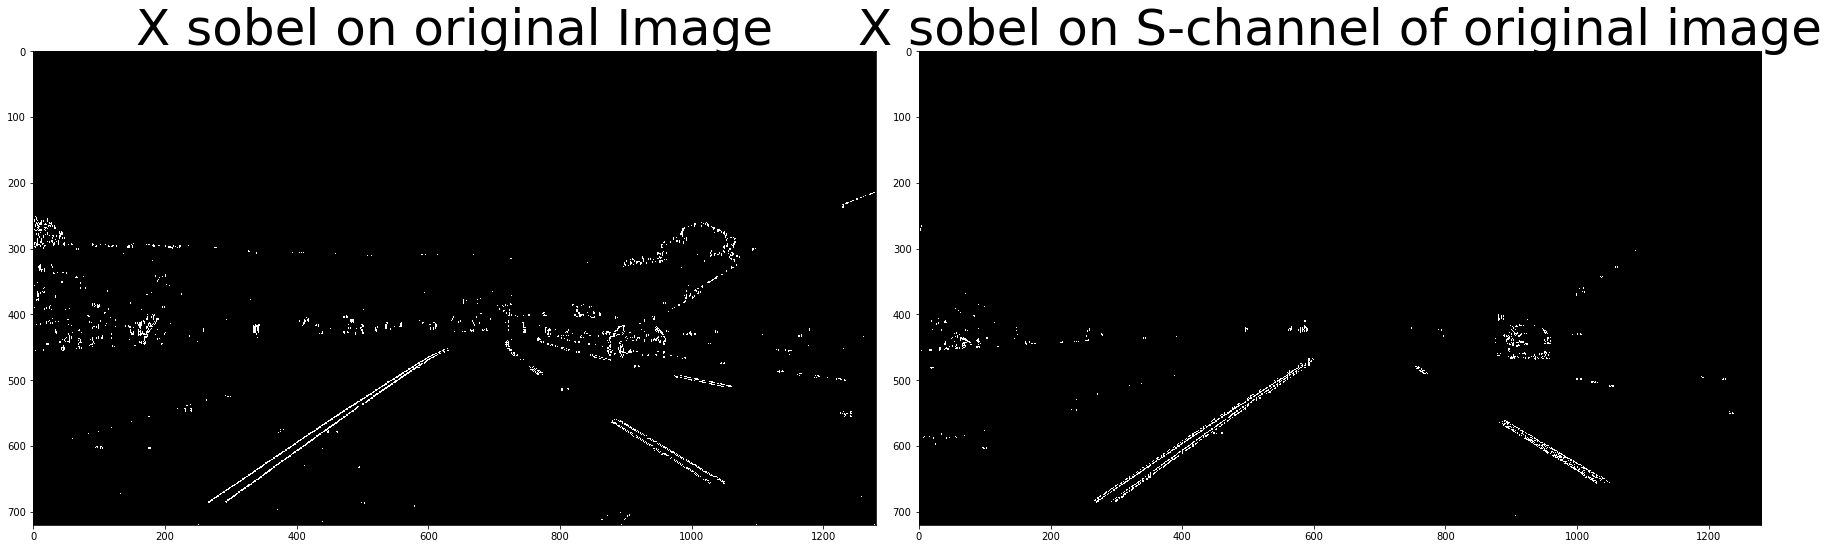

In [19]:
# Choose a Sobel kernel size
ksize = 15

x_thresh = (40, 120)
# Apply sobelx on the original image
gradx_original = abs_sobel_thresh(original_image, orient='x', sobel_kernel=ksize, thresh=x_thresh)
# Apply sobelx on the original image
gradx_sChannel = abs_sobel_thresh(s_channel, orient='x', sobel_kernel=ksize, thresh=x_thresh)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(gradx_original, cmap='gray')
ax1.set_title('X sobel on original Image', fontsize=50)
ax2.imshow(gradx_sChannel, cmap='gray')
ax2.set_title('X sobel on S-channel of original image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

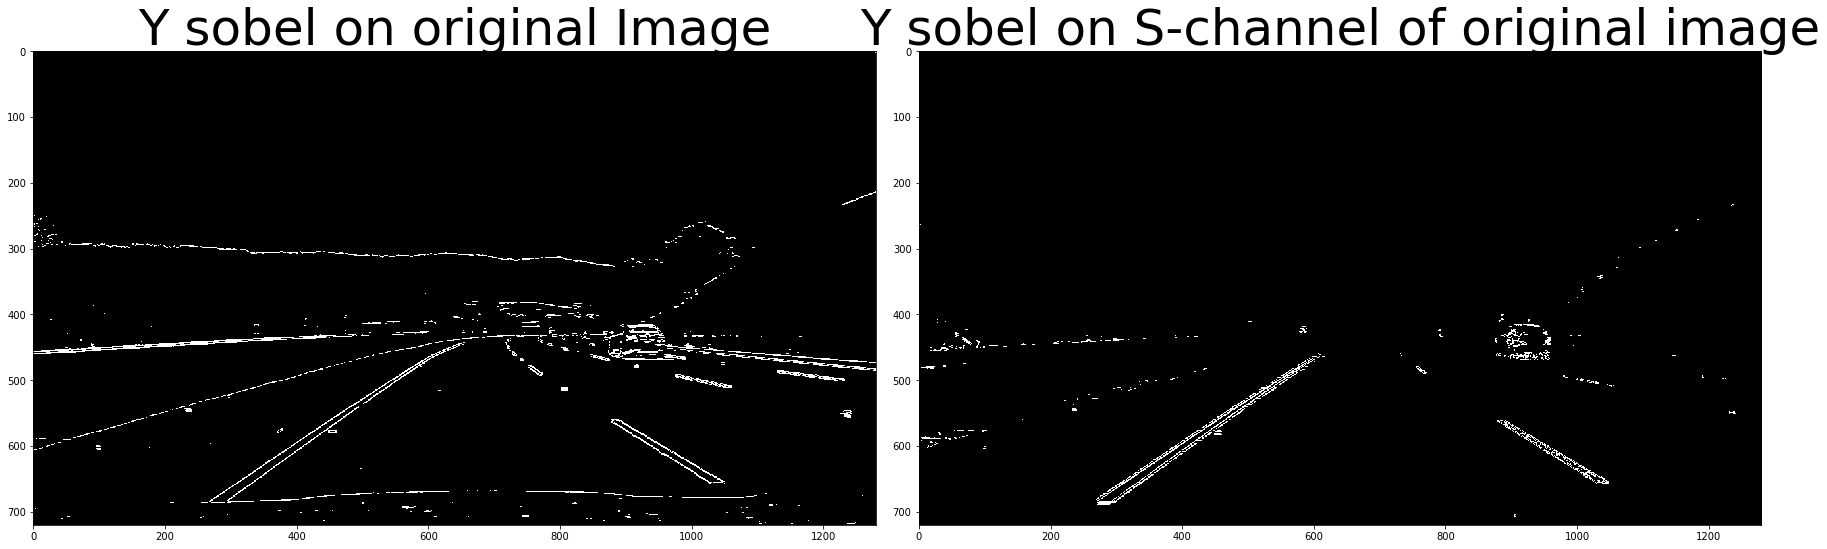

In [20]:
y_thresh = (50, 200)
grady_original = abs_sobel_thresh(original_image, orient='y', sobel_kernel=ksize, thresh=y_thresh)
grady_sChannel = abs_sobel_thresh(s_channel, orient='y', sobel_kernel=ksize, thresh=y_thresh)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(grady_original, cmap='gray')
ax1.set_title('Y sobel on original Image', fontsize=50)
ax2.imshow(grady_sChannel, cmap='gray')
ax2.set_title('Y sobel on S-channel of original image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

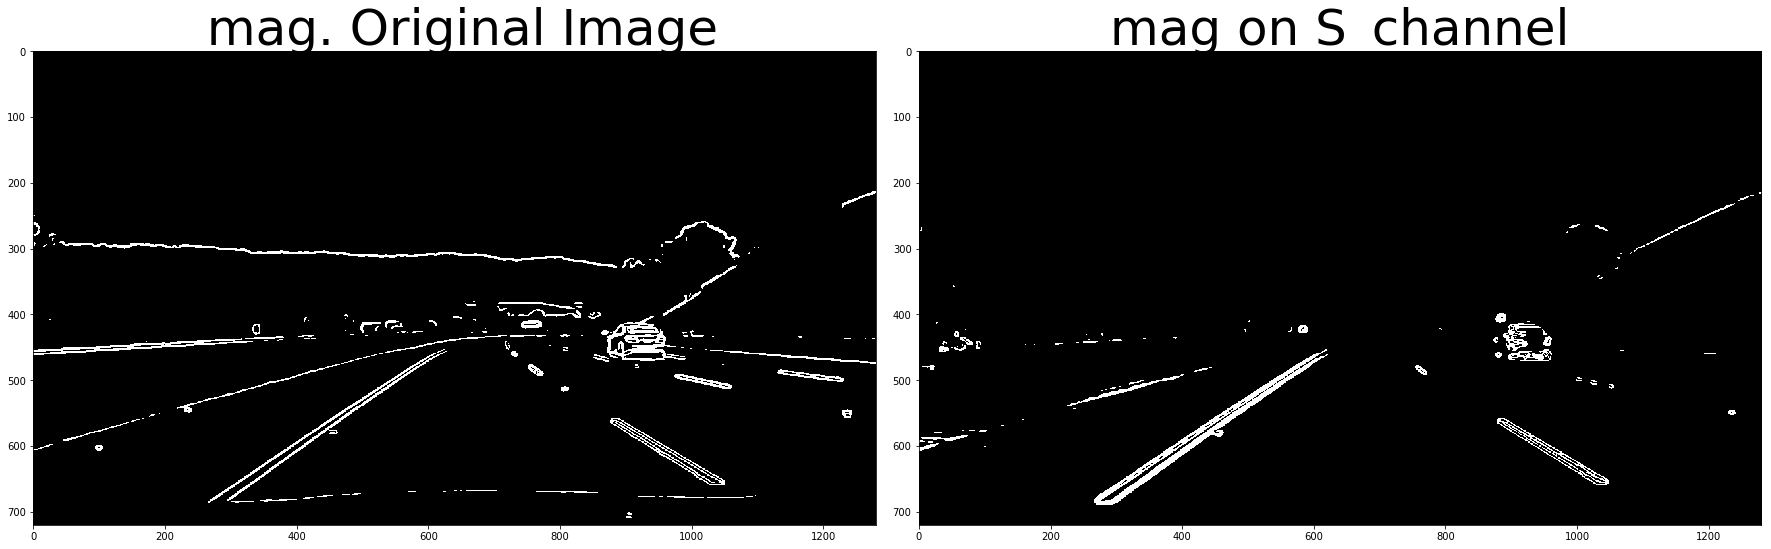

In [21]:
mag_thresh_=(60, 180)
mag_binary_original = mag_thresh(original_image, sobel_kernel=ksize, mag_thresh=mag_thresh_)
mag_binary_sChannel = mag_thresh(s_channel, sobel_kernel=ksize, mag_thresh=mag_thresh_)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(mag_binary_original, cmap='gray')
ax1.set_title(' mag. Original Image', fontsize=50)
ax2.imshow(mag_binary_sChannel, cmap='gray')
ax2.set_title('mag on S_channel', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

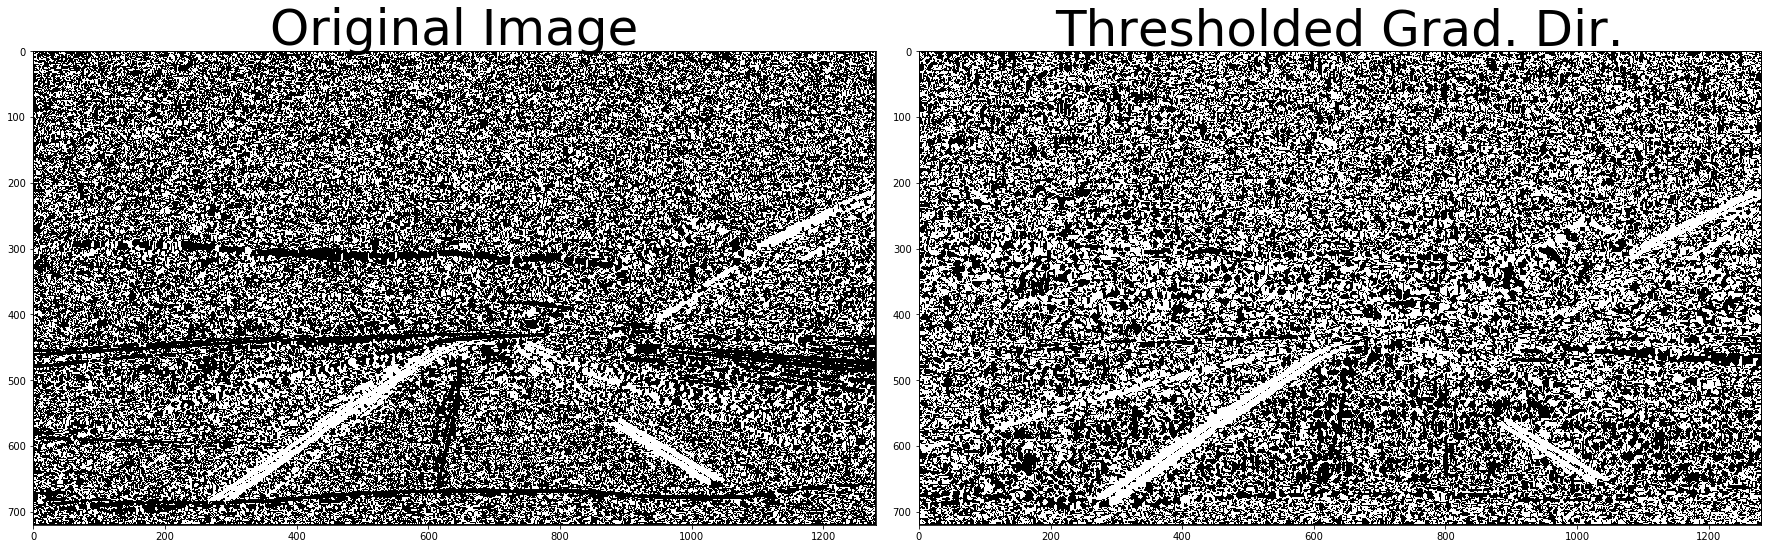

In [22]:
dir_binary_original = dir_threshold(original_image, sobel_kernel=ksize, thresh=(0.7, 1.3))
dir_binary_sChannel = dir_threshold(s_channel, sobel_kernel=ksize, thresh=(0.7, 1.4))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(dir_binary_original, cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary_sChannel, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

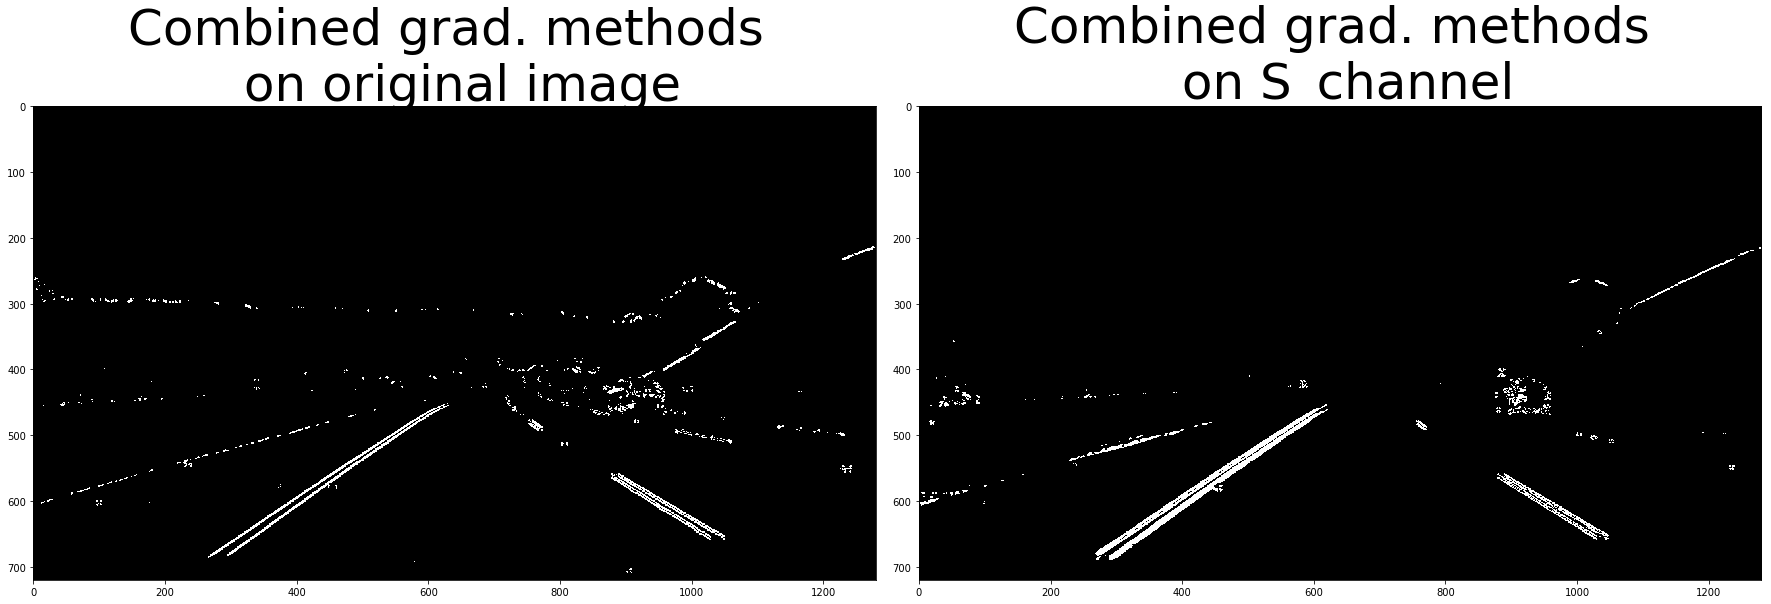

In [23]:
#original image
combined_original = np.zeros_like(dir_binary_original)
combined_original[((gradx_original == 1) & (grady_original == 1)) | ((mag_binary_original == 1) & (dir_binary_original == 1))] = 1

#using s channel only
combined_sChannel = np.zeros_like(dir_binary_sChannel)
combined_sChannel[((gradx_sChannel == 1) & (grady_sChannel == 1)) | ((mag_binary_sChannel == 1) & (dir_binary_sChannel == 1))] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined_original, cmap='gray')
ax1.set_title('Combined grad. methods \n on original image', fontsize=50)
ax2.imshow(combined_sChannel, cmap='gray')
ax2.set_title('Combined grad. methods \n on S_channel',fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [24]:
def apply_gradients (img, ksize=3):
    x_thresh = (40, 120)
    y_thresh = (50, 200)
    mag_thresh_=(60, 180)
    g_thresh = (0.7, 1.3)
    gradx_sChannel = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=x_thresh)
    grady_sChannel = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=y_thresh)
    mag_binary_sChannel = mag_thresh(img, sobel_kernel=ksize, mag_thresh=mag_thresh_)
    dir_binary_sChannel = dir_threshold(img, sobel_kernel=ksize, thresh=g_thresh)
    
    combined_sChannel = np.zeros_like(dir_binary_sChannel)
    combined_sChannel[((gradx_sChannel == 1) & (grady_sChannel == 1)) | ((mag_binary_sChannel == 1) & (dir_binary_sChannel == 1))] = 1
    
    return combined_sChannel

Truncate the image to only a region of interest. The following cells show which region is chosen.

In [25]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

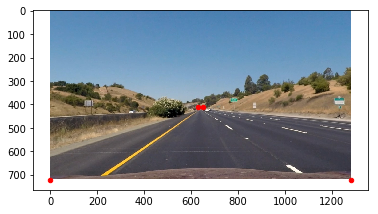

In [45]:
#reading in an image
image = mpimg.imread('test_images/straight_lines1.jpg')
image = cv2.undistort(image, mtx, dist, None, mtx)

# vertices of the polygon
th = 10 #pixels
edge_upper_left = [int(max_x/2)-th,int(max_y/2)+50]
edge_upper_right = [int(max_x/2)+th,int(max_y/2)+50]
edge_lower_left =[0,max_y]
edge_lower_right = [max_x,max_y]
vertices = np.array([edge_upper_left,edge_upper_right,edge_lower_right,edge_lower_left])

# check that they make sense
x_array = [int(max_x/2)-th,int(max_x/2)+th,0,max_x]
y_array = [int(max_y/2)+50, int(max_y/2)+50,max_y, max_y ]
implot = plt.imshow(image)
# put a red dot, size 40, at 2 locations:
plt.scatter(x=x_array, y=y_array, c='r', s=20)
plt.show()

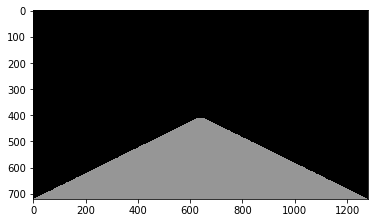

In [27]:
#cropped_image = region_of_interest(combined_sChannel, [vertices])
mask = np.zeros_like(image) 
ignore_mask_color = (150,) * 3
cv2.fillPoly(mask, [vertices], ignore_mask_color)
plt.imshow(mask)
plt.show()

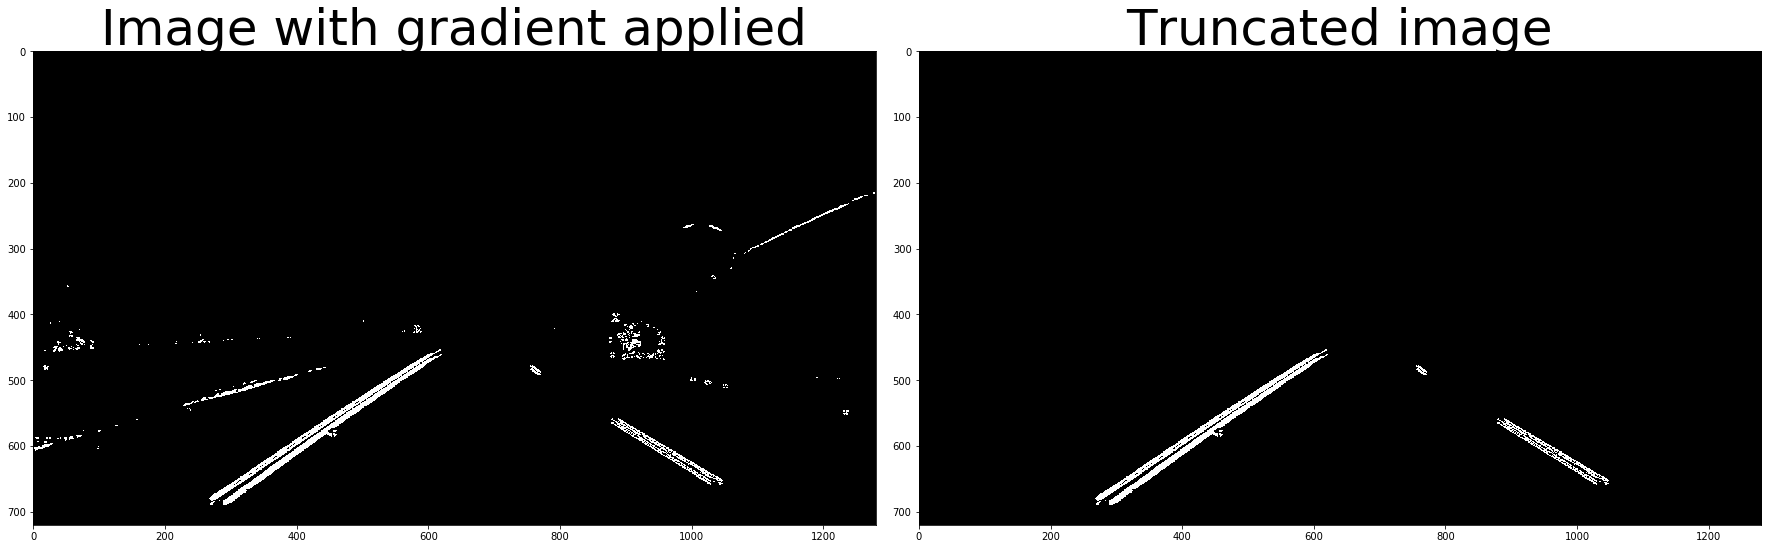

In [28]:
truncated_image = region_of_interest(combined_sChannel, [vertices])
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined_sChannel, cmap='gray')
ax1.set_title('Image with gradient applied', fontsize=50)
ax2.imshow(truncated_image, cmap='gray')
ax2.set_title('Truncated image',fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

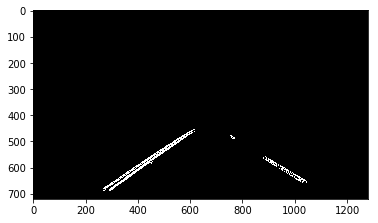

In [29]:
plt.imshow(truncated_image, cmap='gray')
plt.show()

## Perspective change --> Bird view

For this section, we need to use an image for which the camera calibration has been applied as it will be how the pipeline will work.

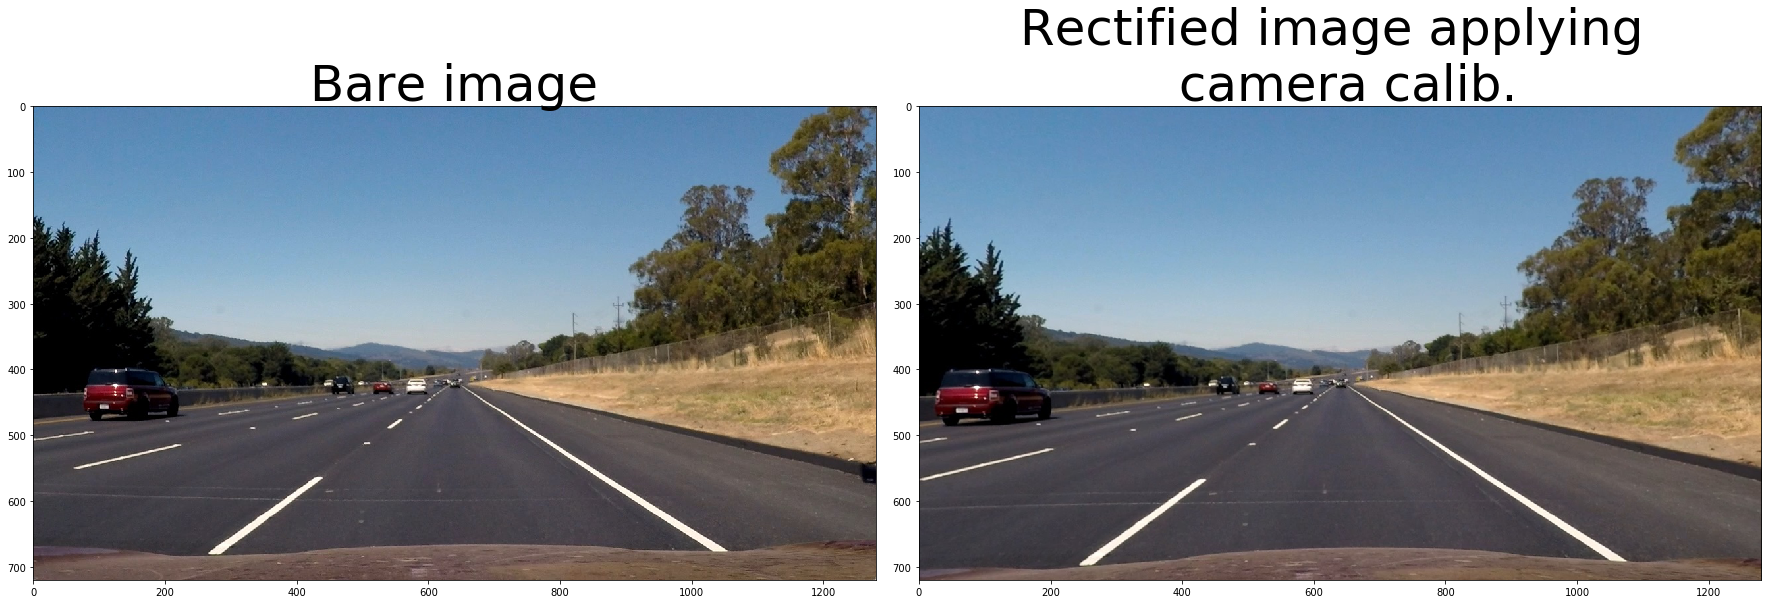

In [30]:
#reading in an image
image = mpimg.imread('test_images/straight_lines2.jpg')

undistorted = cv2.undistort(image, mtx, dist, None, mtx)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Bare image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Rectified image applying \n camera calib.',fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

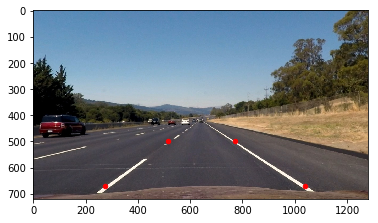

[[  515.   500.]
 [  770.   500.]
 [  275.   670.]
 [ 1040.   670.]]


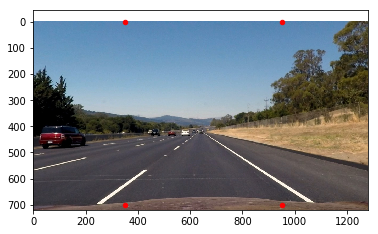

[[ 350.    0.]
 [ 950.    0.]
 [ 350.  700.]
 [ 950.  700.]]


In [31]:
# find the source and destination points
# source points
#x_array = [594,max_x - 590,280,max_x-240]
#y_array = [450, 450,max_y-50, max_y-50 ]
x_array = [515,max_x - 510,275,max_x-240]
y_array = [500, 500,max_y-50, max_y-50 ]
#plot the source points to make sure they make sense
implot = plt.imshow(undistorted)
plt.scatter(x=x_array, y=y_array, c='r', s=20)
plt.show()

src = np.empty(shape = (4,2), dtype = np.float32)
for i, (x, y) in enumerate(zip(x_array, y_array)):
    pt = [x,y]
    src[i] = pt
print(src)

# destination points
dst = np.empty(shape = (4,2), dtype = np.float32)
x_array_dst = [350,950, 350, 950]
y_array_dst = [0, 0, 700, 700 ]
#plot the source points to make sure they make sense
implot = plt.imshow(undistorted)
plt.scatter(x=x_array_dst, y=y_array_dst, c='r', s=20)
plt.show()
for i, (x, y) in enumerate(zip(x_array_dst, y_array_dst)):
    pt = [x,y]
    dst[i] = pt
print(dst)

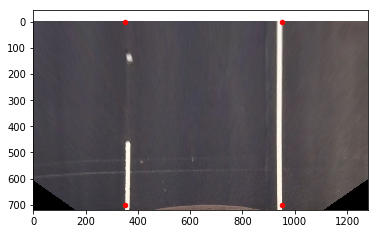

In [32]:
img = undistorted
img_size = (img.shape[1], img.shape[0])

M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(undistorted, M, img_size, flags=cv2.INTER_LINEAR)
implot = plt.imshow(warped)
plt.scatter(x=x_array_dst, y=y_array_dst, c='r', s=20)
plt.show()

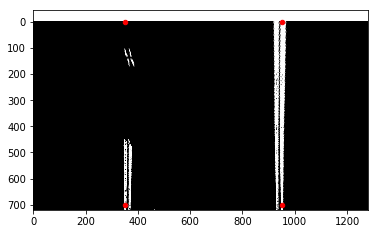

In [33]:
# Now check that it works with the gradient image
grad_img = apply_gradients(undistorted, 15)
img_size = (grad_img.shape[1], grad_img.shape[0])
#M = cv2.getPerspectiveTransform(src, dst)
bird_view_grad = cv2.warpPerspective(grad_img, M, img_size, flags=cv2.INTER_LINEAR)
implot = plt.imshow(bird_view_grad, cmap = 'gray')
plt.scatter(x=x_array_dst, y=y_array_dst, c='r', s=20)
plt.show()

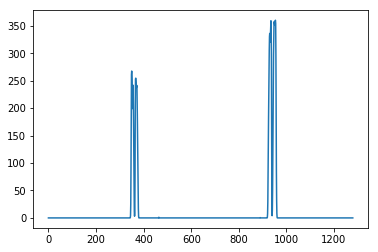

In [34]:
import numpy as np
histogram = np.sum(bird_view_grad[img.shape[0]//2:,:], axis=0)
plt.plot(histogram)

 ## Create the pipeline
 
 Now that we have computed the camera calibration and found the matrix needed to change the perspective of an image, we can call them in a function that processes the image in the following way: 
 * Apply the camera calibration to the incoming image
 * Apply the gradient function to isolate the lanes
 * Truncate the image to the 'zone of interest'
 * Change the perspective to a bird view
 * Identify the lanes
 * Find a fit for the lanes

In [35]:
def region_of_interest_binary(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [36]:
def transform_image(img, calib_matrix, dist_coeffs, brid_view_transform):
    img_size = (img.shape[1], img.shape[0])
    # apply camera calibration on the image
    undistorted_img = cv2.undistort(img, calib_matrix, dist_coeffs, None, calib_matrix)
    # extract_s_channel_from_BGR
    sChannel_img = extract_s_channel_from_RGB(undistorted_img)
    # apply all the gradients function
    grad_img = apply_gradients(sChannel_img, ksize=15)
    grad_img[grad_img>0]=255
    # truncate image to region of interest
    truncated_image = region_of_interest_binary(grad_img, [vertices])
    truncated_image[truncated_image>0]=1
    # change perspective
    bird_view_img = cv2.warpPerspective(truncated_image, brid_view_transform, img_size, flags=cv2.INTER_LINEAR)
    bird_view_img[bird_view_img>0]=1.0
    return bird_view_img

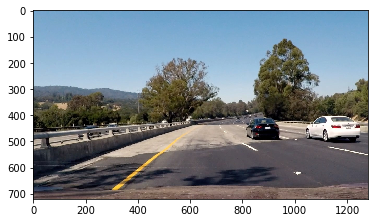

(720, 1280)


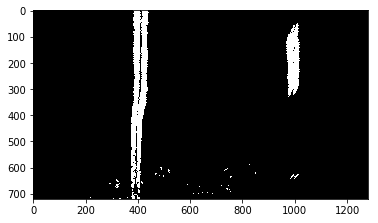

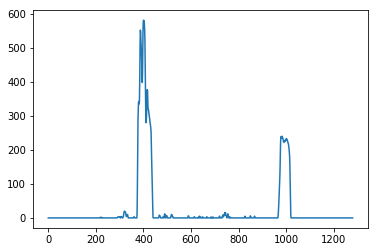

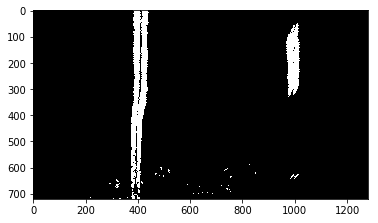

(720, 1280, 3)
0.0
1.0
118842


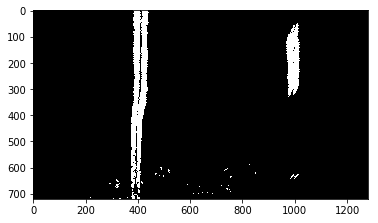

In [37]:
# read an image
image_rot = mpimg.imread('test_images/test4.jpg')
plt.imshow(image_rot)
plt.show()
b = transform_image(image_rot, mtx, dist, M)

print(b.shape)
plt.imshow(b, cmap='gray')
plt.show()

histogram = np.sum(b[img.shape[0]//2**3:,:], axis=0)
plt.plot(histogram)
plt.show()

plt.imshow(b*255, cmap='gray')
plt.show()

out_img =  np.dstack((b, b, b))
print(out_img.shape)
print(out_img.min())
print(out_img.max())
print(np.count_nonzero(out_img))
plt.imshow(out_img)
plt.show()

(720, 1280, 3)
0.0
1.0


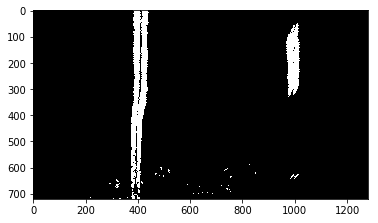

left start 400
right start 982
window height  80


In [38]:
binary_warped = b 
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2**3:,:], axis=0)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))
print(out_img.shape)
print(out_img.min())
print(out_img.max())

plt.imshow(out_img)
plt.show()
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

print('left start',leftx_base)
print('right start',rightx_base)

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
print('window height ', window_height)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin

    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,1,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,1,0), 2)

    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)


[ -7.27486607e-05   6.43001370e-03   4.11568132e+02]
[  3.96029992e-05  -2.35005234e-02   9.96914079e+02]


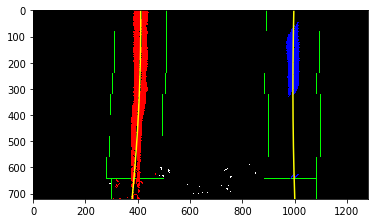

In [39]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

print(left_fit)
print(right_fit)

Calculate the radius of curvature

In [46]:
def calculate_curvature_radius(left_polyfit, right_polyfit, point):
    a_left = np.power((2*left_polyfit[0]+left_polyfit[1]),2)
    a_right = np.power((2*right_polyfit[0]+right_polyfit[1]),2)
    radius_left = np.power(1+a_left,3/2)/np.absolute(2*left_polyfit[0])
    radius_right = np.power(1+a_right,3/2)/np.absolute(2*right_polyfit[0])
    # print(radius_left)
    # print(radius_right)
    return radius_left, radius_right

def calculate_curvature_radius_px_to_m(left_polyfit, right_polyfit, point):
    '''Calculate the radii of curvature for two given polyfit 
    equations and returns the results in meters without decimal values'''
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/600 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    return np.around(calculate_curvature_radius(left_fit_cr,right_fit_cr, y_))
    

In [47]:
y_ = max_y

# in pixels
l, r = calculate_curvature_radius(left_fit, right_fit, y_)
print('radius of curvature:')
print('left: ', l, 'px', 'right: ', r, 'px')

# in meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in the x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
l, r = calculate_curvature_radius(left_fit_cr,right_fit_cr, y_)
print('left: ', l, 'm','right: ', r, 'm')

print(calculate_curvature_radius_px_to_m(left_fit,right_fit, y_ ))

radius of curvature:
left:  6873.38594291 px right:  12635.69643 px
left:  2257.45408126 m right:  4146.87220042 m
[ 1935.  3554.]


In [42]:
def value_from_polyfit(ployfit_array_deg2, x):
    return ployfit_array_deg2[0]*x**2 + ployfit_array_deg2[1]*x + ployfit_array_deg2[2]

def lane_correctly_detected(left_polyfit, right_polyfit, img_size,  min_lane_distance = 450):
    y_max = img_size[1]
    x_max = img_size[0]

    # check the distance between the lanes:
    # => check at y = 0 & y = y_max that the lanes seem well spaced
    lane_distance_OK = None
    
    x_left_low = value_from_polyfit(left_polyfit, y_max)
    x_right_low = value_from_polyfit(right_polyfit, y_max)
    delta_low = x_right_low - x_left_low
    if delta_low < 0:
        lane_distance_OK = False
    else:
        if delta_low > min_lane_distance:
            x_left_upper = value_from_polyfit(left_polyfit, 0)
            x_right_upper = value_from_polyfit(right_polyfit, 0)
            delta_upper = x_right_upper - x_left_upper
            if delta_low < 0:
                lane_distance_OK =  False
            else:
                lane_distance_OK = True

    # check that the radii of curvature makes sense
    # according to: http://onlinemanuals.txdot.gov/txdotmanuals/rdw/horizontal_alignment.htm#BGBHGEGC
    # the min radius is 587 feet (178 m)
    # we will take 50m of margin
    radius_curvature_OK = None
    l, r = calculate_curvature_radius_px_to_m(left_fit,right_fit, y_max)
    if (l < 130) or (r < 130):
        radius_curvature_OK = False
    else:
        radius_curvature_OK = True
        
    return lane_distance_OK and radius_curvature_OK

print(lane_correctly_detected(left_fit, right_fit, [1280,720]))

True
